In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
df_stable = pd.read_csv('../result/t2-stable.csv')
# df_stepup = pd.read_csv('../result/t2-stepup.csv')
df = pd.concat([df_stable, df_stepup], ignore_index=True)
df.shape, df.columns #, df.describe()

((11357, 18),
 Index(['timeout_sec', 'retry_attempts', 'http2MaxRequests',
        'http1MaxPendingRequests', 'consecutive5xxErrors', 'rps_user',
        'avg_latency_ms', 'latency_p99_ms', 'latency_p95_ms', 'latency_p50_ms',
        'success_rate', 'error_rate_5xx', 'inbond_bandwidth',
        'outbond_bandwidth', 'retries_per_sec', 'envoy_cpu_cores',
        'envoy_mem_bytes', 'upstream_rq_pending_overflow'],
       dtype='object'))

In [3]:
# Define feature and target columns
feature_cols = [
    'rps_user', 'avg_latency_ms', 'latency_p95_ms', 'latency_p99_ms',
    'success_rate', 'error_rate_5xx', 
    'inbond_bandwidth','outbond_bandwidth',
    'envoy_cpu_cores', 'envoy_mem_bytes', #'retries_per_sec','upstream_rq_pending_overflow'
]
target_cols = [
    'timeout_sec', 'retry_attempts', 'http2MaxRequests',
    'http1MaxPendingRequests', 'consecutive5xxErrors'
]

# Subset
X = df[feature_cols].copy()
Y = df[target_cols].copy()

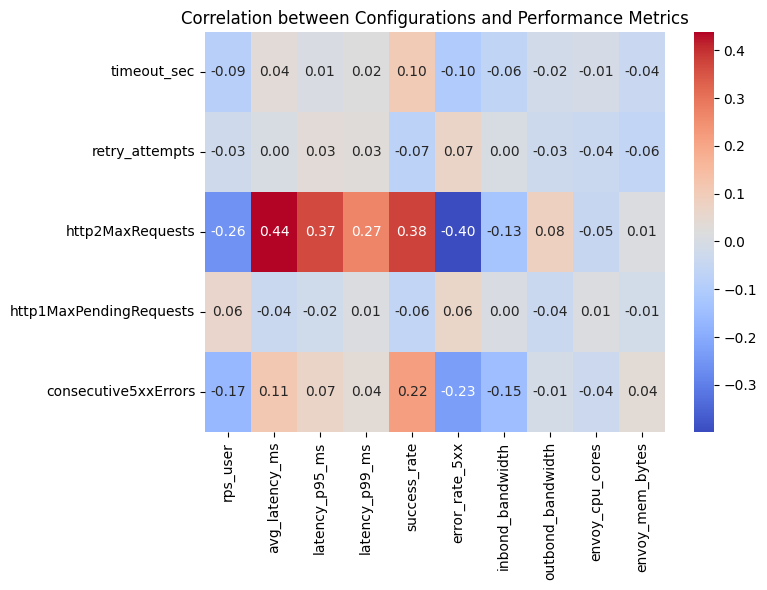

In [8]:
# Compute and display correlation matrix
corr_matrix = df.corr().loc[target_cols, feature_cols]
mean_corr = corr_matrix.abs().mean(axis=1).sort_values(ascending=False)
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Configurations and Performance Metrics")
plt.tight_layout()

In [4]:
# Train Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# X_train.tail(5), Y_train.tail(5)

In [5]:
def _print_regression_report(Y_true, Y_pred, cols):
    """
    Print MSE and R2 for each target column.
    """
    for i, col in enumerate(cols):
        mse = mean_squared_error(Y_true.iloc[:, i], Y_pred[:, i])
        r2 = r2_score(Y_true.iloc[:, i], Y_pred[:, i])
        print(f"Target: {col}")
        print(f"  MSE: {mse:.4f}")
        print(f"  R2:  {r2:.4f}\n")

In [12]:
# Decision Tree

dt = DecisionTreeRegressor(random_state=42)
dt_multi = MultiOutputRegressor(dt)
dt_multi.fit(X_train, Y_train)
y_pred_dt = dt_multi.predict(X_test)
_print_regression_report(Y_test, y_pred_dt, Y.columns)

Target: timeout_sec
  MSE: 0.7629
  R2:  0.2476

Target: retry_attempts
  MSE: 0.4098
  R2:  0.3691

Target: http2MaxRequests
  MSE: 32926.9366
  R2:  0.6786

Target: http1MaxPendingRequests
  MSE: 7095.0704
  R2:  0.2104

Target: consecutive5xxErrors
  MSE: 1.8768
  R2:  0.3240



In [13]:
#SVM 

svr = SVR(kernel='rbf')
svr_multi = MultiOutputRegressor(svr)
svr_multi.fit(X_train, Y_train)
y_pred_svr = svr_multi.predict(X_test)
_print_regression_report(Y_test, y_pred_svr, Y.columns)

Target: timeout_sec
  MSE: 1.0453
  R2:  -0.0309

Target: retry_attempts
  MSE: 0.6496
  R2:  -0.0001

Target: http2MaxRequests
  MSE: 121988.9888
  R2:  -0.1908

Target: http1MaxPendingRequests
  MSE: 10118.6496
  R2:  -0.1261

Target: consecutive5xxErrors
  MSE: 2.7751
  R2:  0.0004



In [15]:
# Random Forest Regressor wrapped for multi-output
rf = RandomForestRegressor(random_state=42)
rf_multi = MultiOutputRegressor(rf)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'estimator__n_estimators': [50, 100, 200],
    'estimator__max_depth': [5, 10, 15, None],
    'estimator__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    rf_multi,
    param_grid=param_grid,
    cv=3,
    scoring='r2',
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train, Y_train)
print("Best parameters found: ", grid_search.best_params_)

Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] END estimator__max_depth=5, estimator__min_samples_split=2, estimator__n_estimators=50; total time=  18.1s
[CV] END estimator__max_depth=5, estimator__min_samples_split=2, estimator__n_estimators=50; total time=  18.6s
[CV] END estimator__max_depth=5, estimator__min_samples_split=2, estimator__n_estimators=50; total time=  18.7s
[CV] END estimator__max_depth=5, estimator__min_samples_split=2, estimator__n_estimators=100; total time=  36.4s
[CV] END estimator__max_depth=5, estimator__min_samples_split=2, estimator__n_estimators=100; total time=  36.9s
[CV] END estimator__max_depth=5, estimator__min_samples_split=5, estimator__n_estimators=50; total time=  17.9s
[CV] END estimator__max_depth=5, estimator__min_samples_split=5, estimator__n_estimators=50; total time=  17.3s
[CV] END estimator__max_depth=5, estimator__min_samples_split=2, estimator__n_estimators=100; total time=  38.1s
[CV] END estimator__max_depth=5, estima

In [16]:
best_rf_multi = grid_search.best_estimator_
y_pred = best_rf_multi.predict(X_test)
_print_regression_report(Y_test, y_pred, Y.columns)

Target: timeout_sec
  MSE: 0.3742
  R2:  0.6309

Target: retry_attempts
  MSE: 0.2164
  R2:  0.6669

Target: http2MaxRequests
  MSE: 15839.5327
  R2:  0.8454

Target: http1MaxPendingRequests
  MSE: 3158.9430
  R2:  0.6485

Target: consecutive5xxErrors
  MSE: 1.0049
  R2:  0.6380



Based on Best parameter found from above.

In [6]:
rf_best = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    random_state=42
)

rf_multi_best = MultiOutputRegressor(rf_best)

# Train the model directly (very fast compared to GridSearch)
rf_multi_best.fit(X_train, Y_train)

# Predict immediately
y_pred = rf_multi_best.predict(X_test)

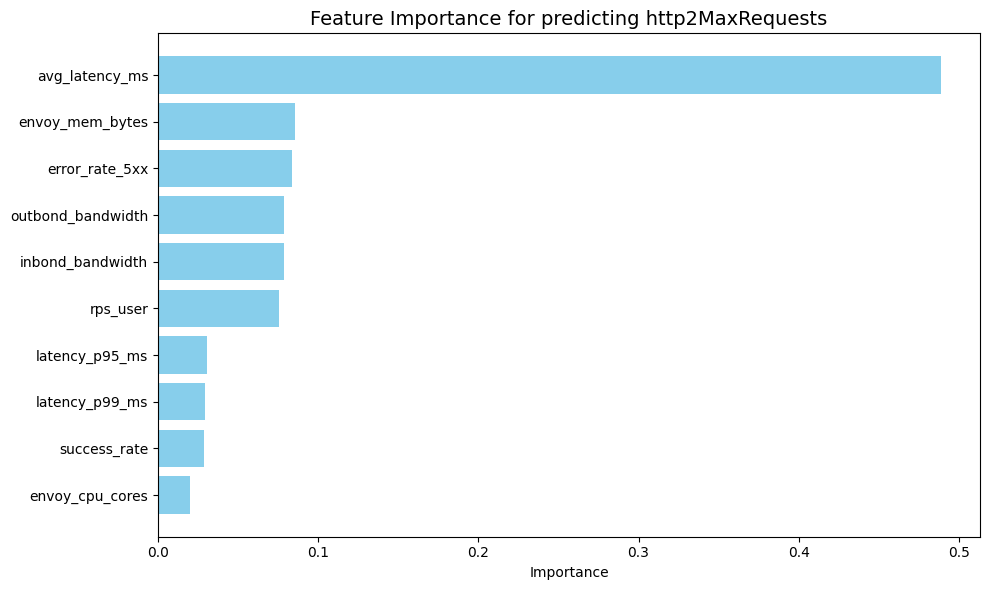

In [10]:
target_name = 'http2MaxRequests' 
target_index = target_cols.index(target_name)

# Extract feature importances from the relevant estimator
rf_estimator = rf_multi_best.estimators_[target_index]
importances = rf_estimator.feature_importances_

# Sort features by importance
indices = np.argsort(importances)

# Plotting
plt.figure(figsize=(10, 6))
plt.title(f'Feature Importance for predicting {target_name}', fontsize=14)
plt.barh(range(len(indices)), importances[indices], align='center', color='skyblue')
plt.yticks(range(len(indices)), [feature_cols[i] for i in indices])
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

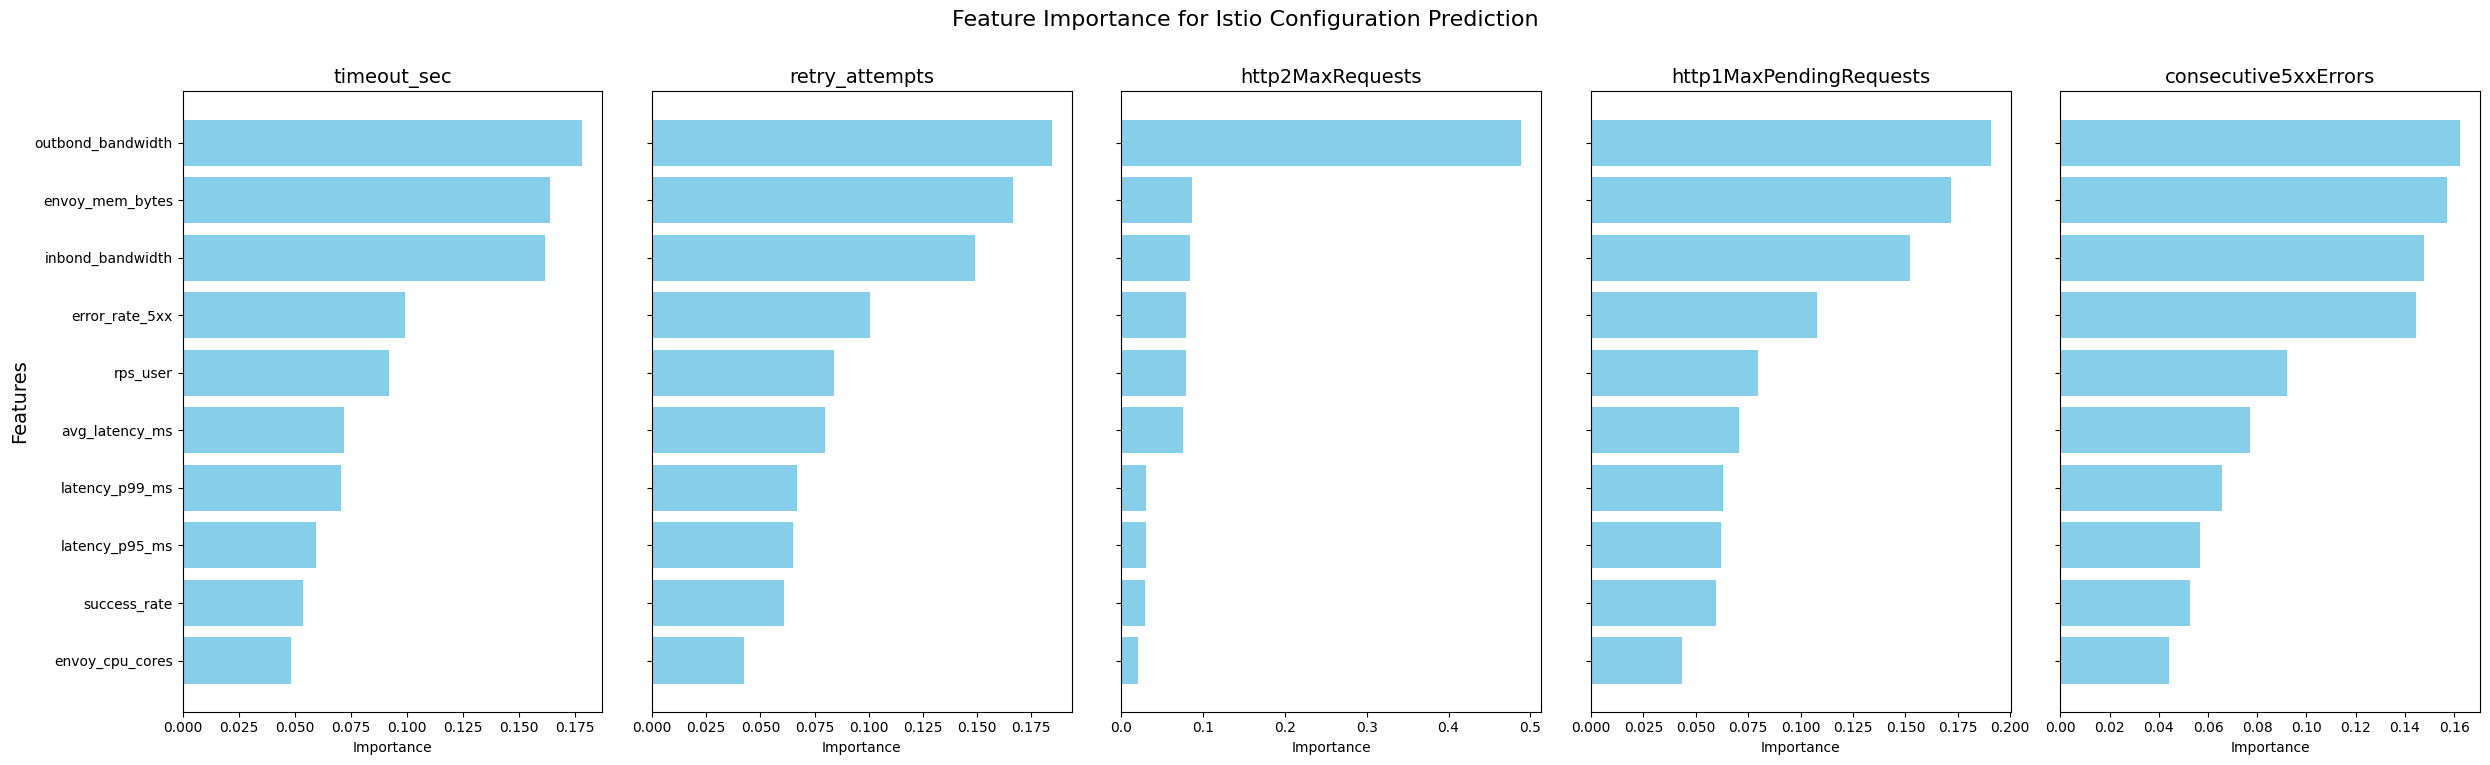

In [12]:

# Number of targets
n_targets = len(target_cols)

# Set up subplot grid
fig, axes = plt.subplots(nrows=1, ncols=n_targets, figsize=(5 * n_targets, 8), sharey=True)

for idx, target_name in enumerate(target_cols):
    rf_estimator = rf_multi_best.estimators_[idx]
    importances = rf_estimator.feature_importances_
    indices = np.argsort(importances)

    # Horizontal bar plot for each target
    ax = axes[idx]
    ax.barh(range(len(indices)), importances[indices], align='center', color='skyblue')
    ax.set_yticks(range(len(indices)))
    ax.set_yticklabels([feature_cols[i] for i in indices])
    ax.set_xlabel('Importance')
    ax.set_title(f'{target_name}', fontsize=14)

# Shared Y-axis label
axes[0].set_ylabel('Features', fontsize=14)

plt.suptitle('Feature Importance for Istio Configuration Prediction', fontsize=16, y=0.95)
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()


In [13]:
corr_matrix = pd.concat([X, Y], axis=1).corr()
print(corr_matrix.loc[feature_cols, target_cols])


                   timeout_sec  retry_attempts  http2MaxRequests  \
rps_user             -0.088036       -0.025669         -0.257239   
avg_latency_ms        0.035008        0.001508          0.437621   
latency_p95_ms        0.005066        0.032776          0.365822   
latency_p99_ms        0.021919        0.026676          0.269415   
success_rate          0.102134       -0.072445          0.377203   
error_rate_5xx       -0.102734        0.067517         -0.398775   
inbond_bandwidth     -0.064095        0.001290         -0.130241   
outbond_bandwidth    -0.017769       -0.031549          0.083308   
envoy_cpu_cores      -0.009837       -0.037669         -0.047235   
envoy_mem_bytes      -0.040902       -0.058203          0.011758   

                   http1MaxPendingRequests  consecutive5xxErrors  
rps_user                          0.059162             -0.165936  
avg_latency_ms                   -0.037476              0.111910  
latency_p95_ms                   -0.021373        